**Tensorflow is one of the top deep learning libraries by google. Originally I used Pytorch as my major 
but recently I decided to explore tensorflow because it abit smooth to deploy trained models to mobile.
It relies on Keras as its high level API. In this code walkthrough am going to use [TFHub](https://www.tensorflow.org/tutorials/images/hub_with_keras) with tranfer learning to classify fruits.**

I am going to use [Fruit dataset](https://www.kaggle.com/moltean/fruits).

**Lets dive in **

In [28]:
# Import Important Libraries
import os # To investigate the data

#Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pathlib
#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Mathematical operation
import numpy as np

In [2]:
# data directories
train_root = "../input/fruits-360_dataset/fruits-360/Training"
test_root = "../input/fruits-360_dataset/fruits-360/Test"

In [3]:
# Investigate our data to acetain that number of classes in training ser equal testing set
len(os.listdir(train_root)),len(os.listdir(test_root))

(95, 95)

In [13]:
# load a sample image
image_path = train_root + "/Apple Braeburn/0_100.jpg"
def image_load(image_path):
    loaded_image = image.load_img(image_path)
    image_rel = pathlib.Path(image_path).relative_to(train_root)
    print(image_rel)
    return loaded_image

Apple Braeburn/0_100.jpg


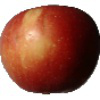

In [14]:
image_load(image_path)

In [7]:
# Loading the data into our model
train_generator = ImageDataGenerator(rescale=1/255) # Training set
test_generator = ImageDataGenerator(rescale=1/255) # Testing set

train_image_data = train_generator.flow_from_directory(str(train_root),target_size=(224,224))
test_image_data = test_generator.flow_from_directory(str(test_root), target_size=(224,224))

Found 48905 images belonging to 95 classes.
Found 16421 images belonging to 95 classes.


TensorFlow Hub also distributes models without the top classification layer, we wil be using
"feature_extractor" for our transfer learning which uses 

In [15]:
# Model url
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2"

In [16]:
# Create the model and check expected Image size
def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))
IMAGE_SIZE

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'.
INFO:tensorflow:Downloaded https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2, Total size: 10.35MB
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'.


[224, 224]

In [17]:
# Check the images shape for train set
for image_batch, label_batch in train_image_data:
    print("Image batch shape:",image_batch.shape)
    print("Label batch shape:",label_batch.shape)
    break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 95)


In [31]:
# Check the images shape for testing set
for test_image_batch, test_label_batch in test_image_data:
    print("Image batch shape:",test_image_batch.shape)
    print("Label batch shape:",test_label_batch.shape)
    break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 95)


In [18]:
# Wrap the the module in a keras layer
feature_extractor_layer = layers.Lambda(feature_extractor,input_shape=IMAGE_SIZE+[3])

In [19]:
# Freeze the variables in the feature extractor so that training only modifies the new classifier layer
feature_extractor_layer.trainable = False

In [20]:
# Attach a classification head
model = Sequential([
    feature_extractor_layer,
    layers.Dense(train_image_data.num_classes, activation = "softmax")
    ])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 95)                121695    
Total params: 121,695
Trainable params: 121,695
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Initialize the TFHub module
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

In [22]:
# Test a siingle batch to see that the result comes back with the expected shape
result = model.predict(image_batch)
result.shape

(32, 95)

# Training the model

In [23]:
# Compile the model with an optimizer
model.compile(
    optimizer = tf.train.AdamOptimizer(),
    loss = "categorical_crossentropy",
    metrics = ['accuracy']
    )

In [25]:
# create a custom callback to visualize the training progress during every epoch
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    
# Implementing early stopping to stop the training if the loss starts to increase and also avoid overvitting
es = EarlyStopping(patience=2,monitor="val_loss")

In [26]:
# Calculate appropriate steps per epoch
steps_per_epoch = train_image_data.samples//train_image_data.batch_size
steps_per_epoch

1528

In [27]:
# Using CallBacks to record accuracy and loss
batch_stats = CollectBatchStats()
# fit model
model.fit((item for item in train_image_data), epochs = 3,
         steps_per_epoch=1528,
         callbacks = [batch_stats, es],validation_data=test_image_data)

Epoch 1/3
1528/1528 [==============================] - 402s 263ms/step - loss: 0.1823 - acc: 0.9728 - val_loss: 0.0567 - val_acc: 0.9884
Epoch 2/3
1528/1528 [==============================] - 313s 205ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.0383 - val_acc: 0.9913
Epoch 3/3
1528/1528 [==============================] - 312s 204ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0323 - val_acc: 0.9907


# Wow we achieving a very high accuracy

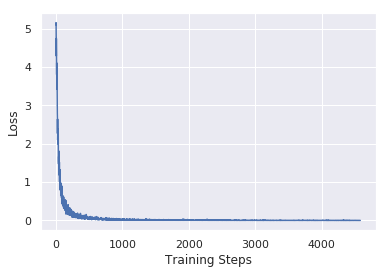

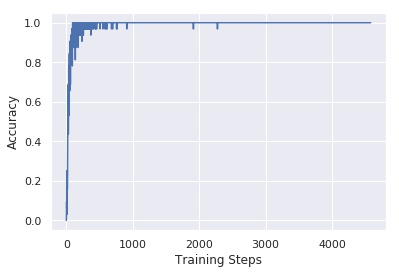

In [29]:
# Visualize the results
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.plot(batch_stats.batch_losses)
plt.savefig("Model Loss")

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.plot(batch_stats.batch_acc)
plt.show()

# Cheking predictions

In [30]:
# Get the ordered list of labels
label_names = sorted(train_image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2',
       'Apple Golden 3', 'Apple Granny Smith', 'Apple Red 1',
       'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious',
       'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado',
       'Avocado Ripe', 'Banana', 'Banana Lady Finger', 'Banana Red',
       'Cactus Fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula',
       'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black',
       'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine',
       'Cocos', 'Dates', 'Granadilla', 'Grape Blue', 'Grape Pink',
       'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4',
       'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut',
       'Huckleberry', 'Kaki', 'Kiwi', 'Kumquats', 'Lemon', 'Lemon Meyer',
       'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mangostan', 'Maracuja',
       'Melon Piel De Sapo', 'Mulberry', 'Nectarine', 'Orange', 'Papaya',
       'Passion Fruit', 'Peach', 'Peac

In [32]:
# Run predictions for the test patch
result_batch = model.predict(test_image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Physalis With Husk', 'Pomegranate', 'Pear Abate', 'Clementine',
       'Cherry Wax Red', 'Lychee', 'Apple Braeburn', 'Maracuja',
       'Hazelnut', 'Hazelnut', 'Pear Abate', 'Cantaloupe 1', 'Peach Flat',
       'Cherry Wax Yellow', 'Pomelo Sweetie', 'Lemon Meyer', 'Pepino',
       'Apple Golden 3', 'Lemon', 'Chestnut', 'Tamarillo', 'Strawberry',
       'Grape Blue', 'Tomato 2', 'Physalis', 'Apple Golden 2', 'Tangelo',
       'Mandarine', 'Papaya', 'Orange', 'Cherry 1', 'Tomato 4'],
      dtype='<U19')

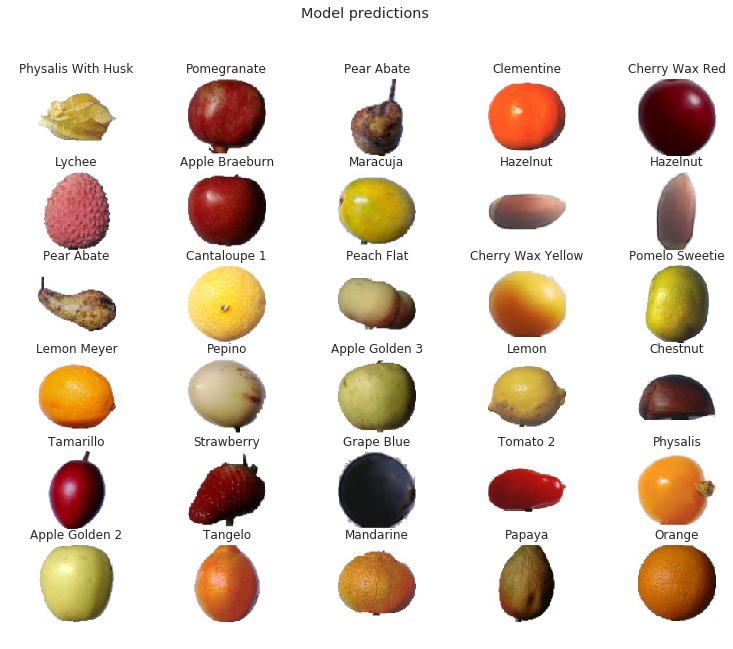

In [36]:
# Show predicted results
plt.figure(figsize=(13,10))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(test_image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
  plt.suptitle("Model predictions")

In [37]:
# Save model for later 
model_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")
print(model_path)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Saver not created becau

**Be sure to commit your code to save outputs**

# *What next*

**Pick an image dataset and try it out**

# **Good Luck**